# COVID-19 transmission in Switzerland

## libraries

In [1]:
## IMPORTS
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi
import pickle

import jax
import jax.numpy as jnp
from jax import random
from jax.experimental.ode import odeint


import arviz as az
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns

import warnings

warnings.filterwarnings('ignore') #suppress warnings

/home/tousside/Documents/AIMS/Courses/BayesianModellingDGSE/project/bayesian-epidemiology-project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Import

In [ ]:
df_swiss = pd.read_csv("swiss_agg_data.csv")
df_swiss['date'] = pd.to_datetime(df_swiss['date'])

df_swiss.head()

,date,onset_dt,test_dt,report_dt,hospit_dt,death_dt,death_dt_hospit,death_dt_nohospit,total_tested
0,2020-01-30,1,0,0,1,0,0,0,40
1,2020-01-31,0,0,0,2,0,0,0,32
2,2020-02-01,3,0,0,2,0,0,0,19
3,2020-02-02,1,0,0,0,0,0,0,11
4,2020-02-03,1,0,0,2,0,0,0,14


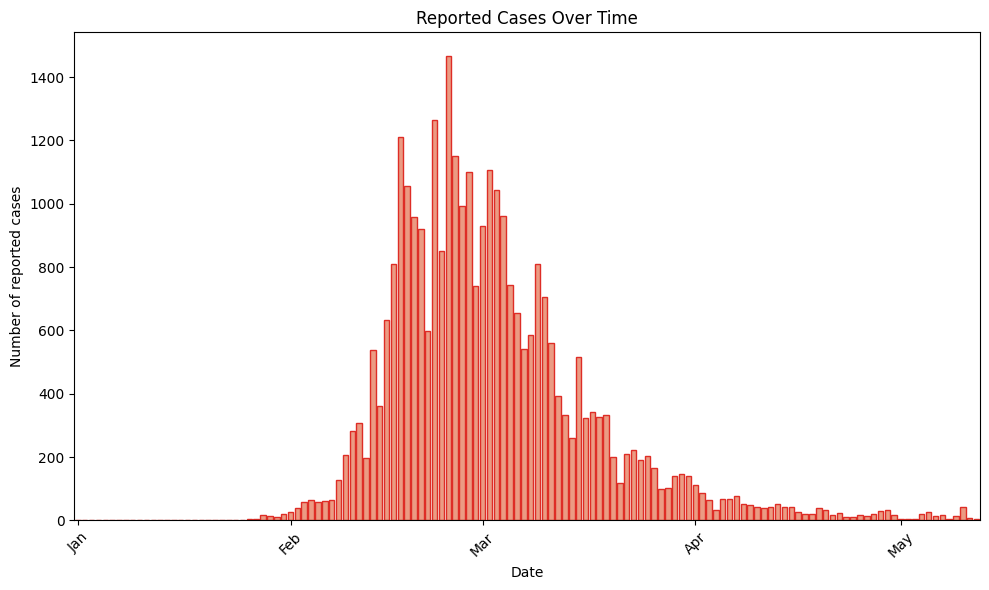

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_swiss, x="date", y="report_dt", color= "#fc9272", edgecolor="#de2d26")

plt.ylabel("Number of reported cases")
plt.xlabel("Date")
plt.title("Reported Cases Over Time")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

## A first Attempt

In [ ]:
def SIR(observed_data=None, pop_size=None,  z_init=None, n_states=3):
    """
    Susceptible-Infectious (SIR) model.

    beta: infection rate (transmission rate).
    gamma: recovered rate.

    S, I : arrays representing the number of susceptible and infected individuals
           at each time step.
    """

    def dz_dt(z, t):
        S = z[0]
        I = z[1]
        R = z[2]

        dS_dt = -beta * I * S / pop_size
        dI_dt =  beta * I * S / pop_size - gamma*I
        dR_dt =  gamma * I

        return jnp.stack([dS_dt, dI_dt, dR_dt])

    if z_init is None:
        z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([n_states]))


    # prior for beta
    beta = numpyro.sample('beta',dist.TruncatedNormal(loc=2, scale=1, low=0.))
    gamma = numpyro.sample('gamma',dist.TruncatedNormal(loc=0.4, scale=0.5, low=0.))

    R0 = numpyro.deterministic("R0", beta / gamma)

    recovery_time = numpyro.deterministic("recovery_time", 1 / gamma)

    #Negative binomial params
    phi_inv = numpyro.sample('phi',dist.Exponential(5))
    phi = 1/phi_inv
    # integrate dz/dt, the result will have shape num_days x 2
    time = jnp.arange(len(observed_data))*1.0

    z = numpyro.deterministic("z", odeint(dz_dt, z_init, time, rtol=1e-6, atol=1e-5, mxstep=1000))

    incidence = z[:-1,0] - z[1:, 0] 
    incidence = numpyro.deterministic("incidence",incidence)

    # likelihood
    obs = numpyro.sample("observed", dist.NegativeBinomial2(incidence+1e-5, phi), obs=observed_data[:-1])


In [ ]:
observed_data = jnp.array(df_swiss['report_dt'])

# inference
nuts_kernel = NUTS(SIR)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=4, progress_bar=True)

#Intial condition
N = 8.57e+6
i0 = 1
s0 = N - i0
r0 = 0

init = jnp.array([s0,i0,r0])
rng_key = jax.random.PRNGKey(0)
prior_predictive = Predictive(SIR, num_samples=1000)
prior_predictions = prior_predictive(rng_key, observed_data=observed_data, pop_size=N)

##### Prior Predictive Check

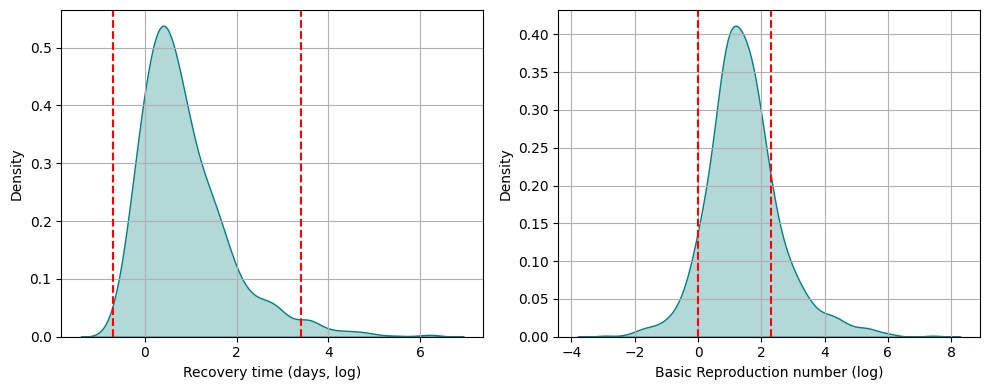

In [ ]:
recovery_time = prior_predictions['recovery_time']
reproduction_number = prior_predictions['R0']
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(jnp.log(recovery_time), alpha=0.3, color='teal', fill = True)
plt.axvline(jnp.log(0.5), color="red", linestyle="--")
plt.axvline(jnp.log(30), color="red", linestyle="--")
plt.xlabel("Recovery time (days, log)")

plt.grid(0.3)

plt.subplot(1, 2, 2)
sns.kdeplot(jnp.log(reproduction_number), alpha=0.3, color='teal', fill = True)
plt.xlabel('Basic Reproduction number (log)')
plt.axvline(jnp.log(1), color="red", linestyle="--")
plt.axvline(jnp.log(10), color="red", linestyle="--")
plt.grid(0.3)
plt.tight_layout()
plt.show()

##### Inference

In [ ]:
mcmc.run(jax.random.PRNGKey(0), pop_size=N,observed_data=observed_data, z_init=init)

sample: 100%|████████████████████████████| 2000/2000 [42:23<00:00,  1.27s/it, 7 steps of size 1.74e-03. acc. prob=0.85]


##### Check convergence

In [ ]:
mcmc.print_summary(exclude_deterministic=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      1.28      1.60      0.46      0.16      4.04       nan   6247.16
     gamma      3.68      2.05      4.02      0.95      5.74      2.00   2044.69
       phi   1459.30   2527.07      0.75      0.19   5843.91      2.00    168.36

Number of divergences: 0


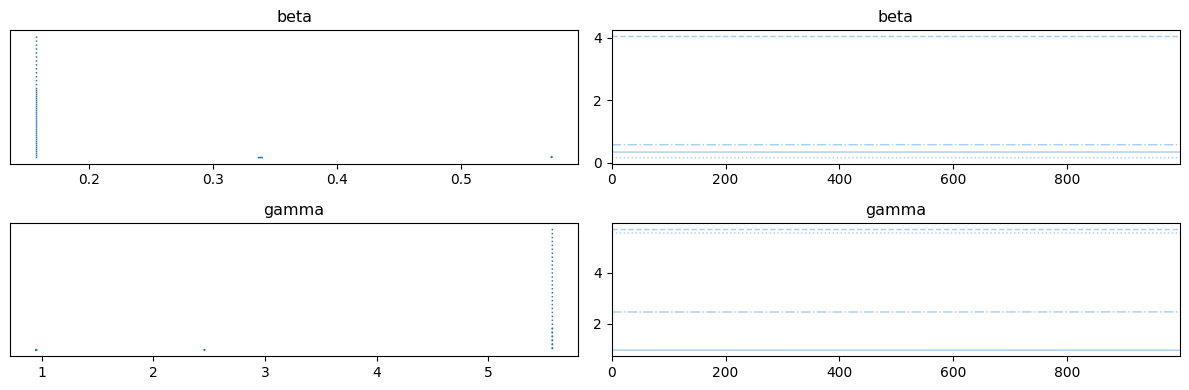

In [ ]:
inf_data = az.from_numpyro(mcmc)
az.plot_trace(inf_data, compact=True, var_names=["beta", "gamma"]);
plt.tight_layout()

##### Model Fit

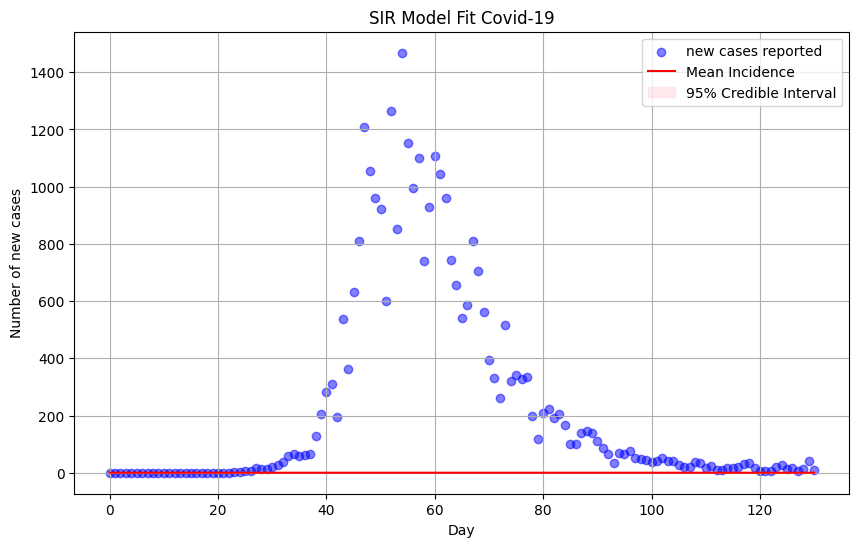

In [ ]:
post_samples_first_attempt = mcmc.get_samples()

observed_samples = post_samples_first_attempt["z"][:,:-1,0]-post_samples_first_attempt["z"][:,1:,0]

lower_bound_nc = jnp.percentile(observed_samples, 2.5, axis=0)
upper_bound_nc = jnp.percentile(observed_samples, 97.5, axis=0)
mean_nc = jnp.mean(observed_samples,axis=0)

plt.figure(figsize=(10, 6))
plt.scatter(jnp.arange(len(observed_data[:-1])), observed_data[:-1], color='blue', alpha=0.5, label='new cases reported')

plt.plot(jnp.arange(len(observed_data[:-1])), mean_nc, color='red', label='Mean Incidence')

# plot uncertainty bounds
plt.fill_between(jnp.arange(len(observed_data[:-1])), lower_bound_nc, upper_bound_nc, color='pink', alpha=0.3, label='95% Credible Interval')

plt.xlabel('Day')
plt.ylabel('Number of new cases')
plt.title('SIR Model Fit Covid-19')
plt.legend()
plt.grid(True)
plt.show()

### Incorporating underreporting

In [ ]:
def SIR(observed_data=None, pop_size=None,  z_init=None, n_states=3):
    """
    Susceptible-Infectious (SIR) model.

    beta: infection rate (transmission rate).
    gamma: recovered rate.

    S, I : arrays representing the number of susceptible and infected individuals
           at each time step.
    """

    def dz_dt(z, t):
        S = z[0]
        I = z[1]
        R = z[2]

        dS_dt = -beta * I * S / pop_size
        dI_dt =  beta * I * S / pop_size - gamma*I
        dR_dt =  gamma * I

        return jnp.stack([dS_dt, dI_dt, dR_dt])

    if z_init is None:
        z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([n_states]))


    # prior for beta
    beta = numpyro.sample('beta',dist.TruncatedNormal(loc=2, scale=1, low=0.))
    gamma = numpyro.sample('gamma',dist.TruncatedNormal(loc=0.4, scale=0.5, low=0.))

    R0 = numpyro.deterministic("R0", beta / gamma)

    recovery_time = numpyro.deterministic("recovery_time", 1 / gamma)
    p_reported = numpyro.sample("p_reported",dist.Beta(1,2))
    #Negative binomial params
    phi_inv = numpyro.sample('phi',dist.Exponential(5))
    phi = 1/phi_inv
    # integrate dz/dt, the result will have shape num_days x 2
    time = jnp.arange(len(observed_data))*1.0

    z = numpyro.deterministic("z", odeint(dz_dt, z_init, time, rtol=1e-6, atol=1e-5, mxstep=1000))

    incidence = (z[:-1,0] - z[1:, 0])*p_reported 
    incidence = numpyro.deterministic("incidence",incidence)

    # likelihood
    obs = numpyro.sample("observed", dist.NegativeBinomial2(incidence+1e-5, phi), obs=observed_data[:-1])


In [ ]:
observed_data = jnp.array(df_swiss['report_dt'])

# inference
nuts_kernel = NUTS(SIR)
mcmc_underreporting = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=4, progress_bar=True)
#Initial condition

N = 8.57e+6
i0 = 1
s0 = N - i0
r0 = 0

init = jnp.array([s0,i0,r0])

##### Prior predictive check

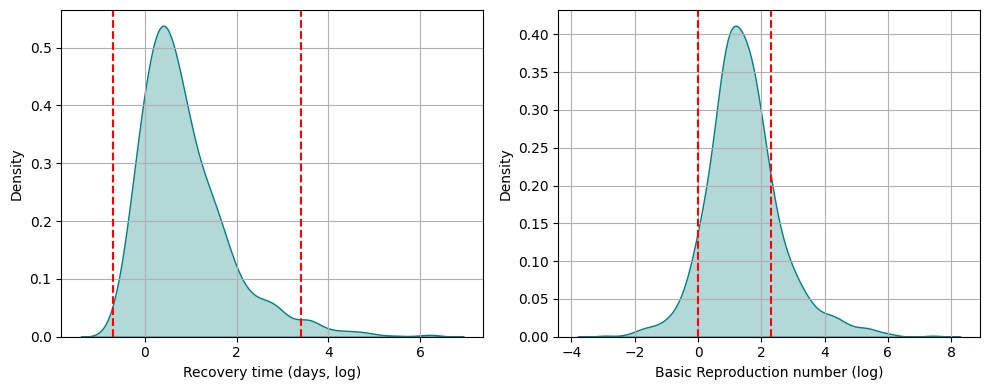

In [ ]:
rng_key = jax.random.PRNGKey(0)
prior_predictive = Predictive(SIR, num_samples=1000)
prior_predictions = prior_predictive(rng_key, observed_data=observed_data, pop_size=N)

recovery_time = prior_predictions['recovery_time']
reproduction_number = prior_predictions['R0']
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(jnp.log(recovery_time), alpha=0.3, color='teal', fill = True)
plt.axvline(jnp.log(0.5), color="red", linestyle="--")
plt.axvline(jnp.log(30), color="red", linestyle="--")
plt.xlabel("Recovery time (days, log)")

plt.grid(0.3)

plt.subplot(1, 2, 2)
sns.kdeplot(jnp.log(reproduction_number), alpha=0.3, color='teal', fill = True)
plt.xlabel('Basic Reproduction number (log)')
plt.axvline(jnp.log(1), color="red", linestyle="--")
plt.axvline(jnp.log(10), color="red", linestyle="--")
plt.grid(0.3)
plt.tight_layout()
plt.show()

##### Inference

In [ ]:
mcmc_underreporting.run(jax.random.PRNGKey(0), pop_size=N,observed_data=observed_data, z_init=init)

sample: 100%|███████████████████████| 2000/2000 [1:09:03<00:00,  2.07s/it, 1023 steps of size 1.30e-04. acc. prob=0.80]


##### Check convergence

In [ ]:
mcmc_underreporting.print_summary(exclude_deterministic=True)


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
        beta      2.47      1.56      2.63      0.57      4.04       nan   4266.92
       gamma      2.60      1.99      2.23      0.23      5.73      2.00   1406.65
  p_reported      0.37      0.14      0.34      0.24      0.58      2.00   1138.78
         phi   2905.68   2905.84   2865.66      0.22   5843.61      2.00    172.75

Number of divergences: 0


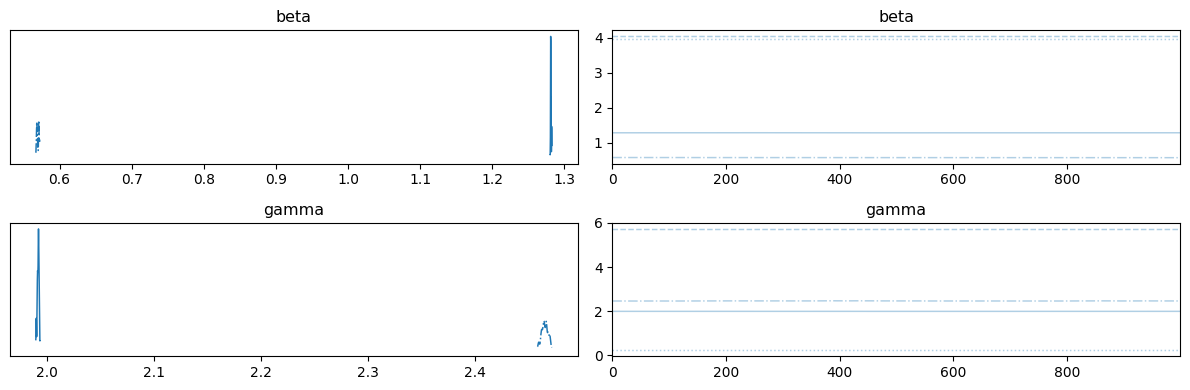

In [ ]:
inf_data = az.from_numpyro(mcmc_underreporting)
az.plot_trace(inf_data, compact=True, var_names=["beta", "gamma"]);
plt.tight_layout()

##### Model Fit

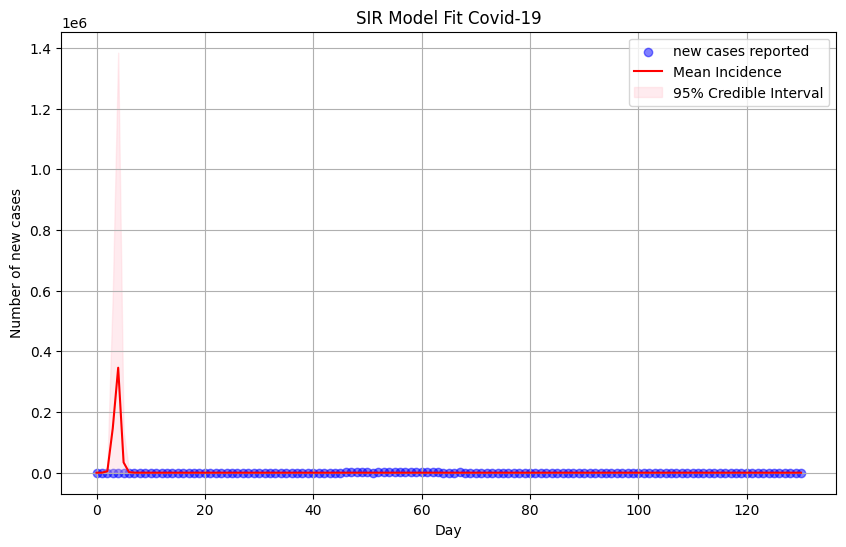

In [ ]:
post_samples_underreporting = mcmc_underreporting.get_samples()
p_reported = post_samples_underreporting["p_reported"]
observed_samples = (post_samples_underreporting["z"][:,:-1,0]-post_samples_underreporting["z"][:,1:,0])*p_reported[:,jnp.newaxis]

lower_bound_nc = jnp.percentile(observed_samples, 2.5, axis=0)
upper_bound_nc = jnp.percentile(observed_samples, 97.5, axis=0)
mean_nc = jnp.mean(observed_samples,axis=0)

plt.figure(figsize=(10, 6))
plt.scatter(jnp.arange(len(observed_data[:-1])), observed_data[:-1], color='blue', alpha=0.5, label='new cases reported')

plt.plot(jnp.arange(len(observed_data[:-1])), mean_nc, color='red', label='Mean Incidence')

# plot uncertainty bounds
plt.fill_between(jnp.arange(len(observed_data[:-1])), lower_bound_nc, upper_bound_nc, color='pink', alpha=0.3, label='95% Credible Interval')

plt.xlabel('Day')
plt.ylabel('Number of new cases')
plt.title('SIR Model Fit Covid-19')
plt.legend()
plt.grid(True)
plt.show()

## Incorportating incubation time and varying initial infections.

In [2]:
numpyro.set_host_device_count(1)

In [8]:
swiss_data = pd.read_csv("swiss_agg_data.csv")

#  Model: SEIR

In [9]:
def SEIR(observed_data=None, num_obs=132, pop_size=None,  z_init=None, n_states=4):
   
    def dz_dt(z, t):
        S = z[0] + z_init[0]
        E = z[1] + z_init[1]
        I = z[2] + z_init[2]
        R = z[3] + z_init[3]

        dS_dt = -beta * I * S / pop_size
        dE_dt =  beta * I * S / pop_size - a*E
        dI_dt =  a*E - gamma*I
        dR_dt =  gamma * I

        return jnp.stack([dS_dt, dE_dt, dI_dt, dR_dt])
        
    
    # prior for beta
    beta = numpyro.sample('beta',dist.TruncatedNormal(loc=2, scale=1, low=0.))
    gamma = numpyro.sample('gamma',dist.TruncatedNormal(loc=0.4, scale=0.5, low=0.))
    a= numpyro.sample('a',dist.TruncatedNormal(loc=0.4, scale=0.5, low=0.))
    I0= numpyro.sample('I0',dist.TruncatedNormal(loc=0, scale=10, low=0.))
    E0= numpyro.sample('E0',dist.TruncatedNormal(loc=0, scale=10, low=0.))

    R0 = numpyro.deterministic("R0", beta / gamma)
    
    recovery_time = numpyro.deterministic("recovery_time", 1 / gamma)
    
    incubation_rate = numpyro.deterministic("Incubation_rate", 1 / a)
        
    #Negative binomial params
    phi_inv = numpyro.sample('phi',dist.Exponential(5))
    phi = 1/phi_inv
    # integrate dz/dt, the result will have shape num_days x 2
    time = jnp.arange(num_obs)*1.0
    
    # Initial condition
    z_init = jnp.array([pop_size-I0-E0, E0, I0, 0])
    p_reported = numpyro.sample('p_reported', dist.Beta(1, 2))
    
    
    z = numpyro.deterministic("z", odeint(dz_dt, z_init, time, rtol=1e-3, atol=1e-2, mxstep=1000))

    # likelihood
    incidence = (z[:-1,1]- z[1:,1] + z[:-1,0]  - z[1:,0])*p_reported
    # incidence = jnp.clip(incidence, min=1e-5)
    obs = numpyro.sample("observed", dist.NegativeBinomial2(incidence, phi), obs=observed_data[:-1])
 

In [19]:
   
# observed data
observed_data = jnp.array(swiss_data["report_dt"])

# inference
nuts_kernel = NUTS(SEIR)
mcmc = MCMC(nuts_kernel, num_samples=500, num_warmup=500, num_chains=2, progress_bar=True)

#Initial condition
mcmc.run(jax.random.PRNGKey(0), pop_size=8.57e6,  observed_data=observed_data)


sample: 100%|██████████| 1000/1000 [03:19<00:00,  5.02it/s, 1023 steps of size 5.58e-06. acc. prob=0.76]


## Summary

In [20]:
mcmc.print_summary(exclude_deterministic=True)


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
          E0      3.41      1.24      3.41      2.17      4.65       nan 518162.72
          I0      3.01      2.36      3.01      0.65      5.37      1.00 1299383.75
           a      1.37      0.82      1.37      0.54      2.19      1.00 203629.45
        beta      0.42      0.08      0.42      0.34      0.50      1.00 376313.88
       gamma      0.59      0.13      0.59      0.46      0.73      1.00  91916.16
  p_reported      0.36      0.01      0.36      0.35      0.37      1.00    778.23
         phi      2.20      1.89      2.20      0.31      4.09      1.00  34659.72

Number of divergences: 647


## Trace plots

OverflowError: cannot convert float infinity to integer

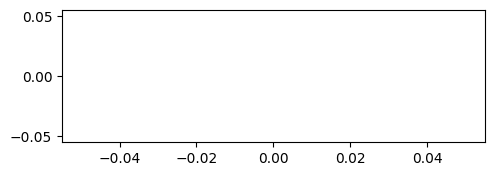

In [18]:
inf_data = az.from_numpyro(mcmc)
az.plot_trace(inf_data, compact=True, var_names=["beta", "gamma", "phi", "R0", "recovery_time"]);
plt.tight_layout();

## Modeling control measures

In [ ]:

def SEIR_with_cm(observed_data=None, num_obs=132, pop_size=None, z_init=None, n_states=4):

    def dz_dt(z, t):
        # Unpack state variables
        S = z[0]
        E = z[1]
        I = z[2]
        R = z[3]

        # Compute the derivatives
        dS_dt = -beta_eff[jnp.array(t, int)] * I * S / pop_size
        dE_dt = beta_eff[jnp.array(t, int)] * I * S / pop_size - a * E
        dI_dt = a * E - gamma * I
        dR_dt = gamma * I

        return jnp.stack([dS_dt, dE_dt, dI_dt, dR_dt])

    # Priors
    beta = numpyro.sample('beta', dist.TruncatedNormal(loc=2, scale=1, low=0.))
    gamma = numpyro.sample('gamma', dist.TruncatedNormal(loc=0.4, scale=0.5, low=0.))
    a = numpyro.sample('a', dist.TruncatedNormal(loc=0.4, scale=0.5, low=0.))
    I0 = numpyro.sample('I0', dist.TruncatedNormal(loc=1, scale=10, low=0.))
    E0 = numpyro.sample('E0', dist.TruncatedNormal(loc=1, scale=10, low=0.))
    p_reported = numpyro.sample('p_reported', dist.Beta(1, 2))
    eta = numpyro.sample('eta', dist.Beta(2.5, 4))
    nu = numpyro.sample('nu', dist.Exponential(1 / 5))
    xi_raw = numpyro.sample('xi_raw', dist.Beta(1, 1))

    # Derived parameters
    xi = numpyro.deterministic("xi", xi_raw + 0.5)
    R0 = numpyro.deterministic("R0", beta / gamma)
    recovery_time = numpyro.deterministic("recovery_time", 1 / gamma)
    incubation_rate = numpyro.deterministic("incubation_rate", 1 / a)

    # Negative binomial dispersion parameter
    phi_inv = numpyro.sample('phi', dist.Exponential(5))
    phi = 1 / phi_inv

    # Time array for integration
    time = jnp.arange(num_obs, dtype=float)

    # Date of introduction of control measures
    control_start_day = 40
    beta_eff = jnp.where(
        time < control_start_day,
        beta,
        beta * eta + (1 - eta) / (1 + jnp.exp(xi * (time - control_start_day - nu)))
    )
    Reff = numpyro.deterministic("Reff", beta_eff / gamma)

    # Effective reproduction number
    Reff = numpyro.deterministic("Reff", beta_eff / gamma)

    # Initial condition for ODE integration
    z_initial = jnp.array([pop_size - I0 - E0, E0, I0, 0.0])

    # Solve ODE for the SEIR model
    z = numpyro.deterministic(
        "z", odeint(dz_dt, z_initial, time, rtol=1e-3, atol=1e-3, mxstep=500)
    )

    # Calculate incidence (new cases)
    incidence = (z[:-1, 1] - z[1:, 1] + z[:-1, 0] - z[1:, 0]) * p_reported

    # Ensure incidence is non-negative
    incidence = jnp.clip(incidence, a_min=1e-5)

    # Likelihood
    numpyro.sample(
        "observed",
        dist.NegativeBinomial2(incidence, phi),
        obs=observed_data[:-1]
    )


In [ ]:
   
# observed data
observed_data = jnp.array(swiss_data["report_dt"])

# inference
nuts_kernel = NUTS(SEIR_with_cm)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=4, progress_bar=True)

#Initial condition
mcmc.run(jax.random.PRNGKey(0), pop_size=8.57e6,  observed_data=observed_data)
